In [1]:
import os
import random

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

# 特徴量選択
from sklearn.feature_selection import (
    SequentialFeatureSelector,
    VarianceThreshold,
    RFE,
    RFECV,
)
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# 機械学習モデル
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析

# 学習中
from tqdm import tqdm
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings

import config

SEED = config.SEED


from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

/Users/masanari/Library/CloudStorage/OneDrive-東京理科大学/projects/breast_cancer_analytics/notebooks/functions.py:242: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


# データ読み込み

In [2]:
X = pd.read_pickle(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X.pkl")
y = pd.read_pickle(config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/y.pkl")

X_train = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_train.pkl"
)
X_test = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_test.pkl"
)
y_train = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/y_train.pkl"
)
y_test = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/y_test.pkl"
)


X_train_chi2 = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_train_chi2.pkl"
)
X_test_chi2 = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_test_chi2.pkl"
)

"""

X_train_chi2_norm = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_train_chi2_norm.pkl"
)
X_test_chi2_norm = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_test_chi2_norm.pkl"
)
"""

X_train_ANOVA = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_train_ANOVA.pkl"
)
X_test_ANOVA = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_test_ANOVA.pkl"
)
"""
X_train_ANOVA_std = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_train_ANOVA_std.pkl"
)
X_test_ANOVA_std = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_test_ANOVA_std.pkl"
)

X_train_ANOVA_norm = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_train_ANOVA_norm.pkl"
)
X_test_ANOVA_norm = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/X_test_ANOVA_norm.pkl"
)
"""
y_train = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/y_train.pkl"
)
y_test = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_OS5YEARS_GENES_DIR + "/y_test.pkl"
)

## ベースラインの精度

全てFalseと予測（学習データはFalseが多いため）した場合のスコア

False    1076
True      344
Name: target_OS_5years, dtype: int64

False    347
True     127
Name: target_OS_5years, dtype: int64

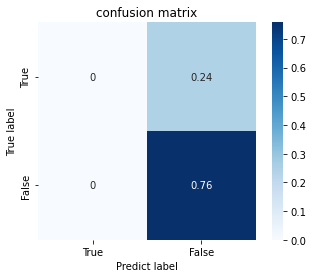

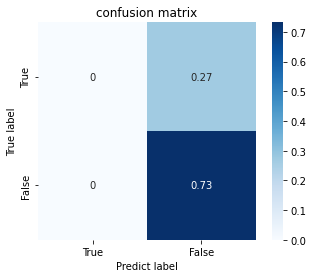

In [3]:
# trainのベースライン
y_train_base = pd.Series([False for i in range(y_train.shape[0])], index=y_train.index)
display(y_train.value_counts())
plot_confusion_matrix(y_train, y_train_base)
# testのベースライン（本命）
y_test_base = pd.Series([False for i in range(y_test.shape[0])], index=y_test.index)
display(y_test.value_counts())
plot_confusion_matrix(y_test, y_test_base)

# 様々な機械学習手法の比較

様々な機械学習手法を用いて2値分類を行う。  
簡単に精度を見るため、再現性は担保されていない（引数にrandom_stateを要求しないclfもあるため）ので、必要に応じて再度モデルを構築すること。  
また、パラメータはデフォルト値を使用している。  
そのためパラメータ次第では結果が向上、下降しうる（決定木のf1など）。  

## 特徴量抽出した各データでの精度比較

### χ^2検定

In [4]:
# 2値分類機の性能比較（特徴量抽出手法：chi2、パラメータ：デフォルト）
display(compare_bcms(X_train_chi2, y_train))
display(compare_bcms(X_train_chi2, y_train, standardization=True))
display(compare_bcms(X_train_chi2, y_train, normalization=True))
display(
    compare_bcms(
        X_train_chi2,
        y_train,
        over_sampling_class=SMOTE(sampling_strategy="minority", random_state=SEED),
    )
)
display(
    compare_bcms(
        X_train_chi2,
        y_train,
        standardization=True,
        over_sampling_class=SMOTE(sampling_strategy="minority", random_state=SEED),
    )
)
display(
    compare_bcms(
        X_train_chi2,
        y_train,
        normalization=True,
        over_sampling_class=SMOTE(sampling_strategy="minority", random_state=SEED),
    )
)

11it [00:36,  3.28s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.682786,0.680282,0.460842,0.450793
Polynomial SVM,0.998826,0.697183,0.997559,0.331930
Decision Tree,1.000000,0.671127,1.000000,0.329489
Nearest Neighbors,0.800235,0.734507,0.475893,0.296069
AdaBoost,0.830203,0.717606,0.571146,0.289049
Linear SVM,0.808607,0.740141,0.465637,0.267489
Logistic Regression,0.800000,0.726761,0.458641,0.264931
Quadratic Discriminant Analysis,0.995931,0.751408,0.991568,0.084749
Random Forest,0.825900,0.755634,0.439261,0.074021


11it [00:25,  2.33s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.682786,0.680282,0.460842,0.450793
Sigmoid SVM,0.713537,0.705634,0.347039,0.331750
Decision Tree,1.000000,0.671127,1.000000,0.329489
Nearest Neighbors,0.802191,0.726761,0.482290,0.292240
AdaBoost,0.830203,0.717606,0.571146,0.289049
Logistic Regression,0.800782,0.724648,0.460955,0.263771
Linear SVM,0.808998,0.738028,0.465391,0.254491
Polynomial SVM,0.860094,0.749296,0.593819,0.140571
Quadratic Discriminant Analysis,0.995931,0.751408,0.991568,0.084749


11it [00:25,  2.34s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.682786,0.680282,0.460842,0.450793
Sigmoid SVM,0.713537,0.705634,0.347039,0.331750
Decision Tree,1.000000,0.671127,1.000000,0.329489
Nearest Neighbors,0.802191,0.726761,0.482290,0.292240
AdaBoost,0.830203,0.717606,0.571146,0.289049
Logistic Regression,0.800782,0.724648,0.460955,0.263771
Linear SVM,0.808998,0.738028,0.465391,0.254491
Polynomial SVM,0.860094,0.749296,0.593819,0.140571
Quadratic Discriminant Analysis,0.995931,0.751408,0.991568,0.084749


11it [01:05,  5.94s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.652941,0.671831,0.635836,0.455169
Nearest Neighbors,0.695041,0.414789,0.764738,0.407257
Random Forest,0.915654,0.693662,0.915672,0.404516
Linear SVM,0.774254,0.616901,0.784981,0.399136
Logistic Regression,0.755253,0.623944,0.760809,0.393565
RBF SVM,0.851941,0.680282,0.853821,0.391571
AdaBoost,0.817030,0.637324,0.821764,0.379442
Sigmoid SVM,0.527290,0.473239,0.528686,0.340594
Polynomial SVM,1.000000,0.683099,1.000000,0.332342


11it [00:49,  4.47s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.652334,0.670423,0.634769,0.452899
Random Forest,0.915859,0.693662,0.915832,0.405152
Sigmoid SVM,0.618227,0.596479,0.617231,0.401512
Nearest Neighbors,0.676807,0.390845,0.754502,0.398857
Logistic Regression,0.761506,0.621831,0.766978,0.386771
Linear SVM,0.776637,0.604225,0.787295,0.378149
AdaBoost,0.815967,0.619718,0.820107,0.357875
RBF SVM,0.947475,0.711972,0.947596,0.343618
Decision Tree,1.000000,0.620423,1.000000,0.326650


11it [00:50,  4.63s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.652334,0.670423,0.634769,0.452899
Random Forest,0.915859,0.693662,0.915832,0.405152
Sigmoid SVM,0.618227,0.596479,0.617231,0.401512
Nearest Neighbors,0.676807,0.390845,0.754502,0.398857
Logistic Regression,0.761506,0.621831,0.766978,0.386771
Linear SVM,0.776637,0.604225,0.787295,0.378149
AdaBoost,0.815967,0.619718,0.820107,0.357875
RBF SVM,0.947475,0.711972,0.947596,0.343618
Decision Tree,1.000000,0.620423,1.000000,0.326650


### ANOVA

In [8]:
'''
# 2値分類機の性能比較（特徴量抽出手法：chi2、パラメータ：デフォルト）
display(compare_bcms(X_train_ANOVA, y_train))
display(compare_bcms(X_train_ANOVA, y_train, standardization=True))
display(compare_bcms(X_train_ANOVA, y_train, normalization=True))
display(
    compare_bcms(
        X_train_ANOVA,
        y_train,
        over_sampling_class=SMOTE(sampling_strategy="minority", random_state=SEED),
    )
)
display(
    compare_bcms(
        X_train_ANOVA,
        y_train,
        standardization=True,
        over_sampling_class=SMOTE(sampling_strategy="minority", random_state=SEED),
    )
)
display(
    compare_bcms(
        X_train_ANOVA,
        y_train,
        normalization=True,
        over_sampling_class=SMOTE(sampling_strategy="minority", random_state=SEED),
    )
)
'''
pass

In [6]:
# 学習データ数
X_train_ANOVA.shape

(1420, 6720)

In [9]:
'''
# chi2にて特徴量選択したデータを元に、各モデルでの学習曲線を可視化
# 正規化したほうが全体的に精度が高かったので、そちらを使用
for estimator in classifiers:
    plot_learning_curve(
        X_train_ANOVA,
        y_train,
        estimator,
        cv=10,
        train_sizes=np.arange(100, int(len(X_train_chi2) * 0.75), 100),
    )
'''
pass

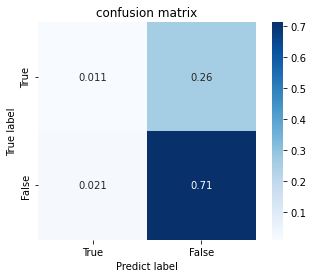

In [10]:
clf_rf = RandomForestClassifier(random_state=SEED)
clf_rf.fit(X_train_ANOVA, y_train)
pred_tmp = clf_rf.predict(X_test_ANOVA)

plot_confusion_matrix(y_test, pred_tmp)

# Wrapper メソッド

## SFS(Sequential Feature Selection): 逐次特徴選択

https://qiita.com/FukuharaYohei/items/db88a8f4c4310afb5a0d

In [ ]:
X_train_chi2.shape

In [ ]:
# Forward Selection
%time

sel = VarianceThreshold()

# ランダムフォレストを使う
rf = RandomForestClassifier()

# 50個に制限
selector = SequentialFeatureSelector(rf, n_features_to_select=50, cv=10)
X_train_front_selected = pd.DataFrame(
    selector.fit_transform(X_train_chi2, y_train),
    columns=X_train_chi2.columns.values[selector.get_support()],
)
result = pd.DataFrame(
    selector.get_support(),
    index=X_train_chi2.columns.values,
    columns=["False: dropped"],
)
print(result)

In [ ]:
X_train_front_selected

In [ ]:
# 2値分類機の性能比較（パラメータ：デフォルト）
compare_bcms(X_train_front_selected, y_train)

In [ ]:
%%time
selector = SequentialFeatureSelector(
    rf, n_features_to_select=30, direction="backward", cv=5
)

X_train_back_selected = pd.DataFrame(
    selector.fit_transform(X_train_front_selected, y_train),
    columns=X_train_front_selected.columns.values[selector.get_support()],
)
result = pd.DataFrame(
    selector.get_support(),
    index=X_train_front_selected.columns.values,
    columns=["False: dropped"],
)
print(result)

In [ ]:
# 2値分類機の性能比較（パラメータ：デフォルト）
compare_bcms(X_train_back_selected, y_train)

In [ ]:
# chi2にて特徴量選択したデータを元に、各モデルでの学習曲線を可視化
for estimator in classifiers:
    plot_learning_curve(
        X_train_back_selected,
        y_train,
        estimator,
        train_sizes=np.arange(100, int(len(X_train_chi2) * 0.75), 100),
    )

# RFE

1. 全特徴量で訓練しモデルを生成
2. 最低のFeature Importnace/ Coef の特徴量を1つ減らして訓練しモデルを生成
3. 2のステップを残す特徴量の数に達するまで繰り返し

In [ ]:
%%time
selector = RFE(rf, n_features_to_select=8)


X_train_rfe = pd.DataFrame(
    selector.fit_transform(X_train_chi2, y_train),
    columns=X_train_chi2.columns.values[selector.get_support()],
)
result = pd.DataFrame(
    selector.get_support(),
    index=X_train_chi2.columns.values,
    columns=["False: dropped"],
)
result["ranking"] = selector.ranking_
print(result)

In [ ]:
display(compare_bcms(X_train_rfe, y_train))
# chi2にて特徴量選択したデータを元に、各モデルでの学習曲線を可視化
for estimator in classifiers:
    plot_learning_curve(
        X_train_rfe,
        y_train,
        estimator,
        train_sizes=np.arange(100, int(len(X_train_chi2) * 0.75), 100),
    )

## BorutaPyを使用した特徴量選択

random forestを用いた特徴量選択手法

SCORE with ALL Features: 0.73

選択された特徴量の数: 58
[False False False ... False False False]
Index(['BE351020', 'CDCA5', 'FAM83D', 'TUBA3C', 'SLC31A1', 'GPR126', 'SCAF4',
       'F2RL1', 'STC2', 'LAD1', 'TMEM42', 'ABHD14A', 'OPRL1', 'CDC20',
       'KDELR2', 'PSMB7', 'TRIB3', 'BX109404', 'CDCA7', 'GGA2', 'BX100511',
       'IGFALS', 'PPP4R4', 'ZCWPW1', 'MAPT', 'CYB5D2', 'NPAS1', 'SOX11',
       'ESR1', 'ACADSB', 'PREX1', 'MFSD2A', 'IL6ST', 'BCL2', 'MUC6', 'TCAP',
       'CASC5', 'TMUB2', 'PPIL3', 'MUC19', 'C6orf97', 'ARPC5L', 'ABHD8',
       'ASB13', 'TH', 'FGD3', 'TMEM26', 'SCUBE2', 'GARS', 'SPINT1', 'LRRC8A',
       'DNALI1', 'WDR19', 'ARIH1', 'CBX2', 'C1orf106', 'PPM1M', 'IDUA'],
      dtype='object')
SCORE with selected Features: 0.84
accuracy:  0.7215189873417721
precision:  0.38095238095238093
recall:  0.06299212598425197
f1 score:  0.1081081081081081


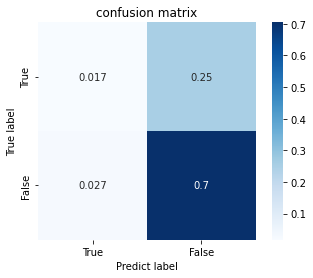

In [22]:
from boruta import BorutaPy

rf1 = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=SEED)
rf1.fit(X_train, y_train)
print("SCORE with ALL Features: %1.2f\n" % rf1.score(X_test, y_test))

# RandomForestRegressorでBorutaを実行
rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=SEED)
feat_selector_rf = BorutaPy(rf, n_estimators="auto", verbose=0, random_state=SEED)
feat_selector_rf.fit(X_train.values, y_train.values)

# 選択された特徴量を確認
selected_boruta = feat_selector_rf.support_
print("選択された特徴量の数: %d" % np.sum(selected_boruta))
print(selected_boruta)
print(X_train.columns[selected_boruta])

# 選択した特徴量で学習
X_train_boruta = X_train[X_train.columns[selected_boruta]]
rf2 = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=SEED)
rf2.fit(X_train_boruta, y_train)
print("SCORE with selected Features: %1.2f" % rf2.score(X_train_boruta, y_train))

X_test_boruta = X_test[X_test.columns[selected_boruta]]
pred_boruta_rf = rf2.predict(X_test_boruta)
show_scores(y_test, pred_boruta_rf)
plot_confusion_matrix(y_test, pred_boruta_rf)

In [38]:
rf2.feature_importances_

array([0.0178037 , 0.01435667, 0.01658247, 0.0166307 , 0.0170937 ,
       0.01924334, 0.01658995, 0.0124753 , 0.02047292, 0.01210869,
       0.01317757, 0.01270461, 0.02105203, 0.01304489, 0.02288562,
       0.01546748, 0.01792112, 0.00926786, 0.0145498 , 0.01888144,
       0.01894803, 0.01663474, 0.02354488, 0.01723578, 0.01230185,
       0.01351581, 0.01291561, 0.00979883, 0.01439885, 0.01034286,
       0.02682864, 0.0202862 , 0.01408921, 0.03032978, 0.01589951,
       0.01510597, 0.02182309, 0.01594919, 0.01836746, 0.01834278,
       0.01733353, 0.01462387, 0.01314347, 0.02239623, 0.02058306,
       0.02338079, 0.01795393, 0.01554235, 0.02237893, 0.02706576,
       0.01837983, 0.01526513, 0.02059172, 0.02384405, 0.01715789,
       0.01986847, 0.01194698, 0.00957506])

Text(0.5, 1.0, 'feature importances')

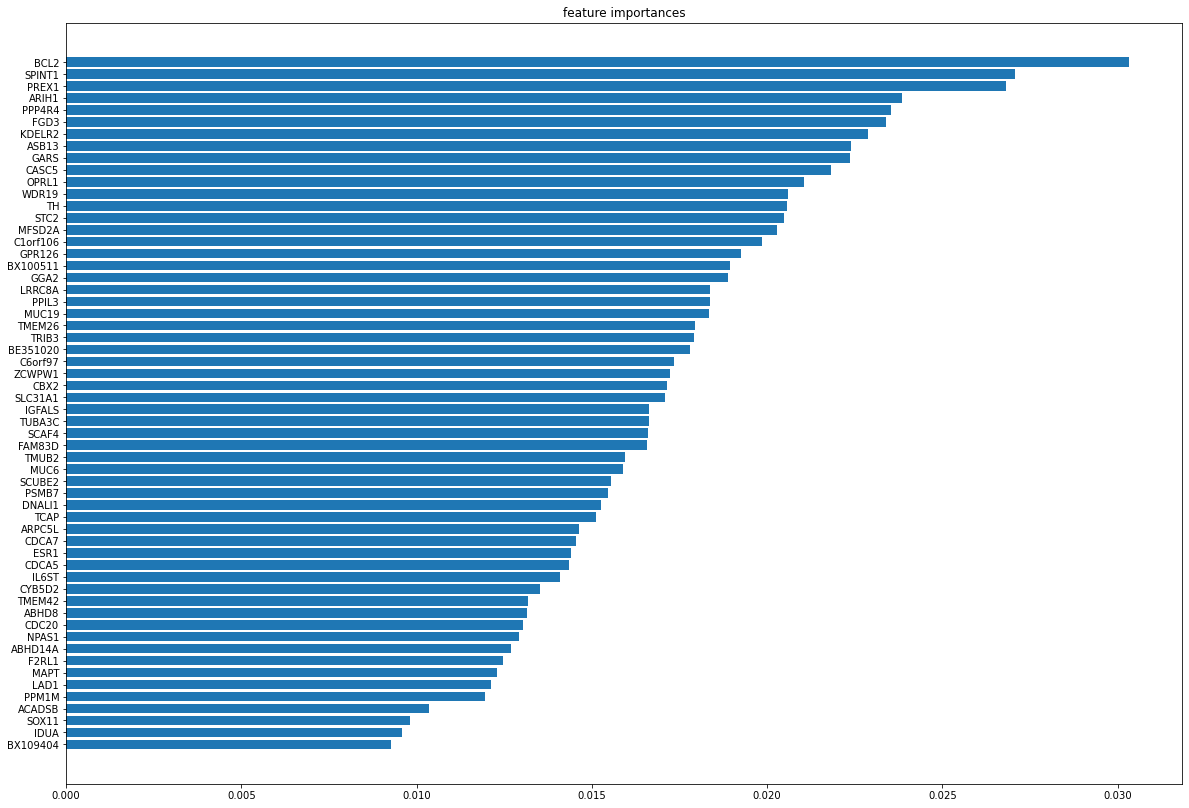

In [61]:
feature_importance = pd.DataFrame(
    {
        "gene_expression": X_test_boruta.columns.values,
        "importance": rf2.feature_importances_,
    }
)
feature_importance.sort_values(by="importance", ascending=True, inplace=True)

plt.figure(figsize=(20, 14))
plt.barh(feature_importance.gene_expression, feature_importance.importance)
plt.title("feature importances")

/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


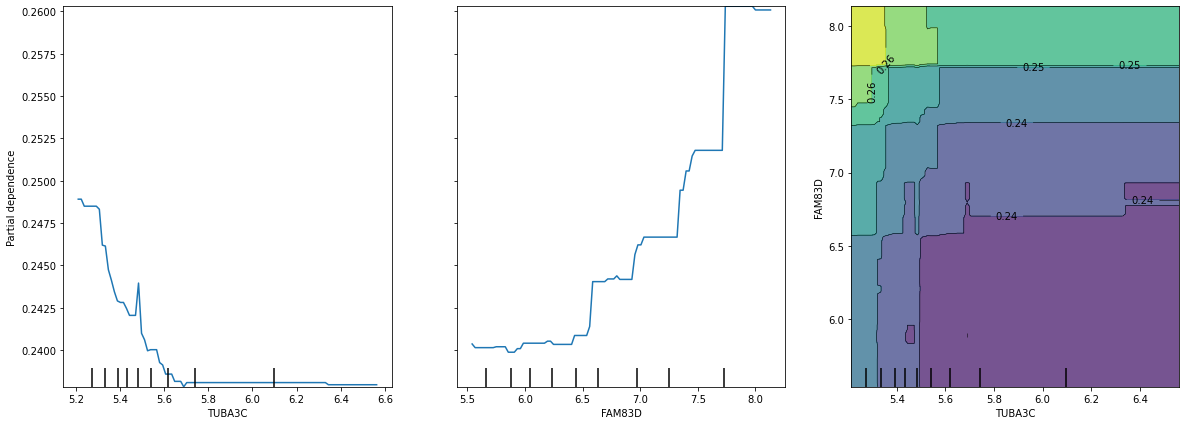

In [36]:
# まだよくわからん
from sklearn.inspection import plot_partial_dependence

fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(1, 1, 1)
plot_partial_dependence(rf2, X_test_boruta, (3, 2, [3, 2]), target=1, ax=ax)

In [32]:
display(compare_bcms(X_train_boruta, y_train))
display(compare_bcms(X_train_boruta, y_train, standardization=True))
display(compare_bcms(X_train_boruta, y_train, normalization=True))
display(compare_bcms(X_train_boruta, y_train, standardization=True, normalization=True))

11it [00:16,  1.53s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.705556,0.703521,0.487615,0.473986
Quadratic Discriminant Analysis,0.876917,0.751408,0.738815,0.425818
AdaBoost,0.847183,0.758451,0.625284,0.396234
Polynomial SVM,0.898826,0.757746,0.750491,0.374585
Logistic Regression,0.797027,0.780986,0.421436,0.364486
Decision Tree,1.000000,0.643662,1.000000,0.314741
Random Forest,1.000000,0.778873,1.000000,0.303604
Nearest Neighbors,0.812050,0.745775,0.467591,0.286983
Linear SVM,0.791080,0.777465,0.328159,0.263666


11it [00:13,  1.22s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.705556,0.703521,0.487615,0.473986
Quadratic Discriminant Analysis,0.876917,0.751408,0.738815,0.425818
AdaBoost,0.847183,0.758451,0.625284,0.396234
Logistic Regression,0.797809,0.777465,0.425317,0.354799
RBF SVM,0.859155,0.786620,0.603680,0.338365
Sigmoid SVM,0.719562,0.716197,0.345159,0.338313
Nearest Neighbors,0.821596,0.773944,0.491612,0.316960
Decision Tree,1.000000,0.643662,1.000000,0.314741
Random Forest,1.000000,0.778873,1.000000,0.303604


11it [00:13,  1.20s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.705556,0.703521,0.487615,0.473986
Quadratic Discriminant Analysis,0.876917,0.751408,0.738815,0.425818
AdaBoost,0.847183,0.758451,0.625284,0.396234
Logistic Regression,0.797809,0.777465,0.425317,0.354799
RBF SVM,0.859155,0.786620,0.603680,0.338365
Sigmoid SVM,0.719562,0.716197,0.345159,0.338313
Nearest Neighbors,0.821596,0.773944,0.491612,0.316960
Decision Tree,1.000000,0.643662,1.000000,0.314741
Random Forest,1.000000,0.778873,1.000000,0.303604


11it [00:13,  1.23s/it]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.705556,0.703521,0.487615,0.473986
Quadratic Discriminant Analysis,0.876917,0.751408,0.738815,0.425818
AdaBoost,0.847183,0.758451,0.625284,0.396234
Logistic Regression,0.797809,0.777465,0.425317,0.354799
RBF SVM,0.859155,0.786620,0.603680,0.338365
Sigmoid SVM,0.719562,0.716197,0.345159,0.338313
Nearest Neighbors,0.821596,0.773944,0.491612,0.316960
Decision Tree,1.000000,0.643662,1.000000,0.314741
Random Forest,1.000000,0.778873,1.000000,0.303604


SCORE with selected Features: 0.70
accuracy:  0.6497890295358649
precision:  0.3872832369942196
recall:  0.5275590551181102
f1 score:  0.44666666666666666


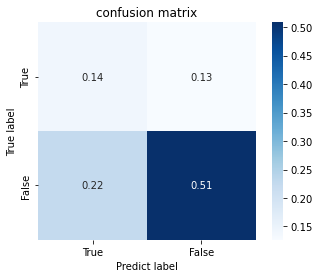

In [33]:
nbayes = GaussianNB()
nbayes.fit(X_train_boruta, y_train)
print("SCORE with selected Features: %1.2f" % nbayes.score(X_train_boruta, y_train))
pred_boruta_nbayes = nbayes.predict(X_test_boruta)
show_scores(y_test, pred_boruta_nbayes)
plot_confusion_matrix(y_test, pred_boruta_nbayes)

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings

warnings.resetwarnings()

warnings.simplefilter("error")


def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 1, 1000)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    max_depth = trial.suggest_int("max_depth", 1, 1000)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 1, 1000)
    bootstrap = trial.suggest_categorical("bootstrap", ["True", "False"])

    clf_rf = RandomForestClassifier(
        bootstrap=bootstrap,
        criterion=criterion,
        max_depth=max_depth,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_jobs=2,
        random_state=SEED,
    )

    clf_rf.fit(X_train_chi2, y_train)

    return accuracy_score(y_test, clf_rf.predict(X_test_chi2))

# パラメータチューニング

## optunaによるパラメータチューニング

[I 2022-07-06 18:23:44,153] A new study created in memory with name: no-name-44c26a18-45a2-4d8d-b9b4-ae39bf5edc69
[I 2022-07-06 18:23:44,170] Trial 0 finished with value: 0.7088607594936709 and parameters: {'n_estimators': 3, 'criterion': 'entropy', 'max_depth': 755, 'min_samples_leaf': 7, 'min_samples_split': 2, 'max_features': 'log2', 'max_leaf_nodes': 87, 'bootstrap': 'True'}. Best is trial 0 with value: 0.7088607594936709.
[I 2022-07-06 18:23:44,250] Trial 1 finished with value: 0.729957805907173 and parameters: {'n_estimators': 39, 'criterion': 'gini', 'max_depth': 903, 'min_samples_leaf': 9, 'min_samples_split': 4, 'max_features': 'log2', 'max_leaf_nodes': 920, 'bootstrap': 'False'}. Best is trial 1 with value: 0.729957805907173.
[I 2022-07-06 18:23:45,701] Trial 2 finished with value: 0.740506329113924 and parameters: {'n_estimators': 598, 'criterion': 'entropy', 'max_depth': 490, 'min_samples_leaf': 2, 'min_samples_split': 2, 'max_features': 'log2', 'max_leaf_nodes': 651, 'boot

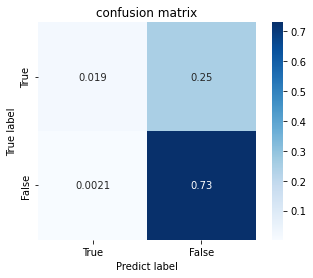

In [36]:
# optunaで学習
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# チューニングしたハイパーパラメーターをフィット
optimised_rf = RandomForestClassifier(
    bootstrap=study.best_params["bootstrap"],
    criterion=study.best_params["criterion"],
    max_depth=study.best_params["max_depth"],
    max_features=study.best_params["max_features"],
    max_leaf_nodes=study.best_params["max_leaf_nodes"],
    n_estimators=study.best_params["n_estimators"],
    min_samples_split=study.best_params["min_samples_split"],
    min_samples_leaf=study.best_params["min_samples_leaf"],
    n_jobs=2,
)

optimised_rf.fit(X_train_chi2, y_train)

pred_tmp = optimised_rf.predict(X_test_chi2)

plot_confusion_matrix(y_test, pred_tmp)